# 3. Tuberculosis
- **Project: Analysis of the dynamics of COVID-19 infection in Colombia**
- **Analysis: Time Series**
- **Data: SIVIGILA - TB rate by epidemiological period in Colombia [2017-2020]**
- **Created by: Andrés Segura Tinoco**
- **Created on: August 1, 2020**
- **Updated on: August 11, 2020**

In [1]:
# Import Python libraries
import pandas as pd
import numpy as np
import itertools
import timeit
from scipy import stats
from math import pi, sqrt, ceil, log
from warnings import catch_warnings
from warnings import filterwarnings

In [2]:
# Import Parallel libraries
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

In [3]:
# Import Time Series libraries
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# Import Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Index
1. Visual Analytics
2. Base Line
3. Time Series Analysis
4. Box-Jenkins Analysis
5. Holt-Winters Analysis
6. Compare Models

#### Load full data

In [5]:
# Read raw data
data_url = '../data/tb_weekly_data.csv'
rawdata = pd.read_csv(data_url, parse_dates=['date'])
rawdata = rawdata[rawdata['date'] >= '2017-01-01']
rawdata

,date,year,month,week,period,value
52,2017-01-01,2017,1,1,1,298
53,2017-01-08,2017,1,2,1,256
54,2017-01-15,2017,1,3,1,347
55,2017-01-22,2017,1,4,1,289
56,2017-01-29,2017,1,5,2,312
...,...,...,...,...,...,...
219,2020-03-15,2020,3,12,3,264
220,2020-03-22,2020,3,13,4,186
221,2020-03-29,2020,3,14,4,178
222,2020-04-05,2020,4,15,4,121


In [6]:
# Grouping by epidemiological period
dataset = rawdata.groupby(['year', 'period']).agg('sum')
dataset = dataset.drop(columns=['month', 'week'])

for ix, row in dataset.iterrows():
    curr_date = min(rawdata[(rawdata['year'] == ix[0]) & (rawdata['period'] == ix[1])]['date'])
    dataset.at[ix, 'date'] = pd.to_datetime(curr_date).date()

dataset.reset_index(inplace=True)
dataset = dataset.reindex(columns=['date', 'year', 'period', 'value'])
dataset = dataset.set_index('date')
dataset

,year,period,value
date,,,
2017-01-01,2017,1,1190
2017-01-29,2017,2,1188
2017-02-26,2017,3,1209
2017-03-26,2017,4,1184
2017-04-23,2017,5,1151
2017-05-21,2017,6,1190
2017-06-18,2017,7,1105
2017-07-16,2017,8,1101
2017-08-13,2017,9,1151


## 1. Visual Analytics

### 1.1. Plot full data

In [7]:
# Create pretty x axis labels
def get_x_labels(all_labels):
    x_labels = []
    for ix in range(len(all_labels)):
        if ix % 5 == 0:
            date_label = str(all_labels[ix]).replace('T', '*').split('*')[0]
            x_labels.append(date_label)
        else:
            x_labels.append('')
    return x_labels

In [8]:
# Cooking weekly data
x_date = np.array(dataset.index)
x_data = np.array(range(len(x_date))).reshape((-1, 1))
y_data = np.array(dataset.value)
xticks = get_x_labels(x_date)
max_y = int(max(y_data) * 1.1)

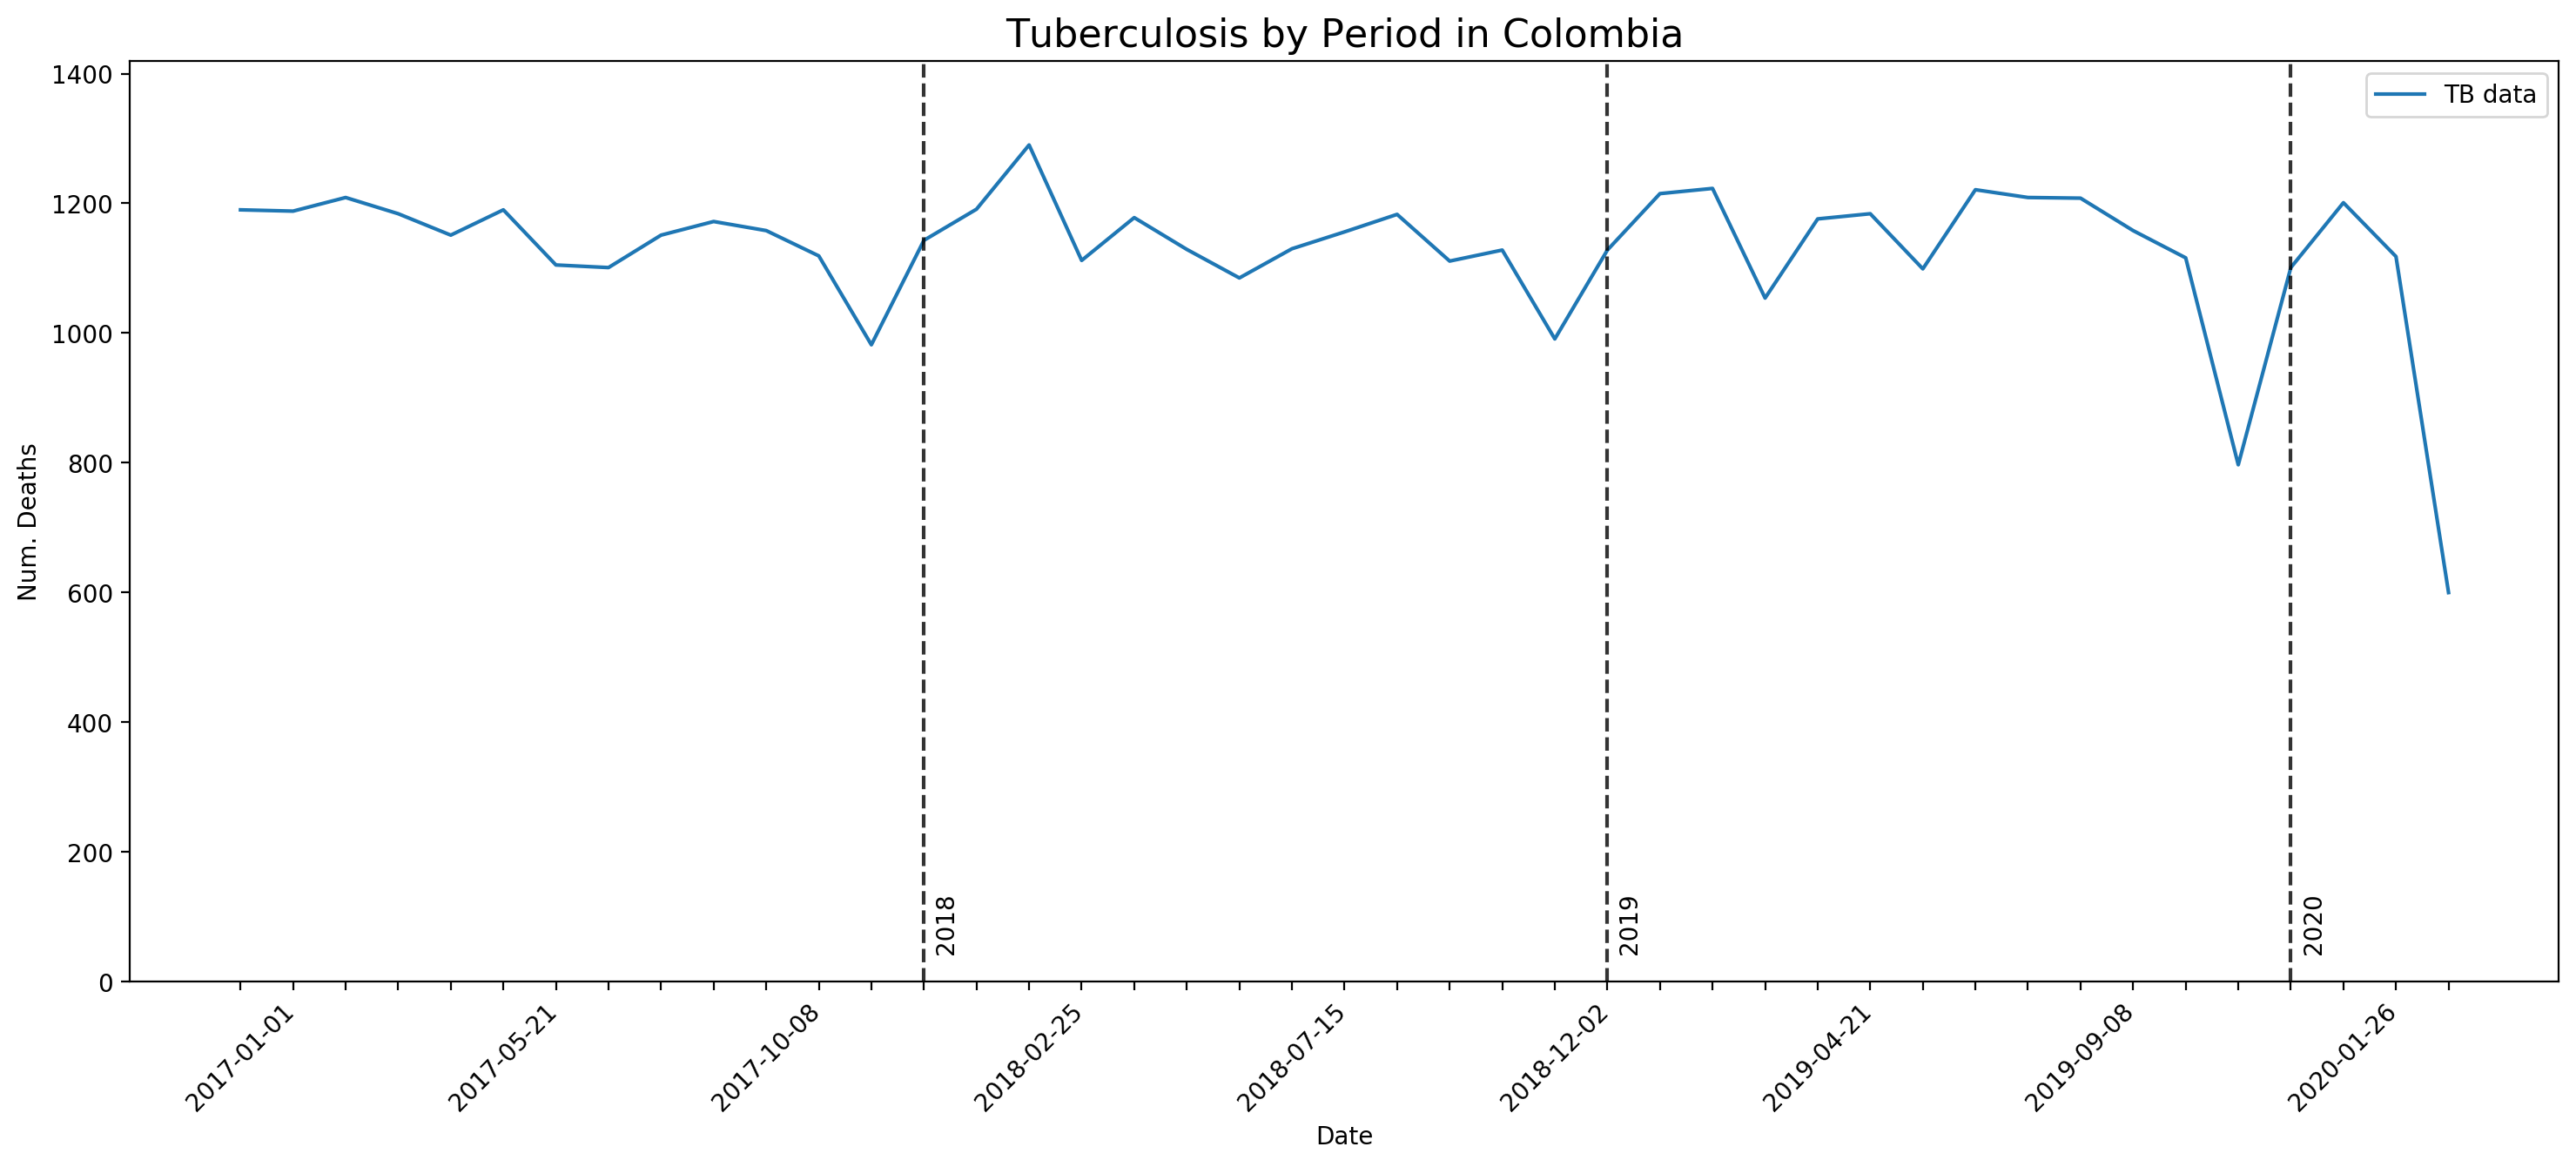

In [9]:
# Plot raw data
plt.figure(figsize=(18, 7), dpi=200)
plt.plot(x_data, y_data, label='TB data')
plt.ylim((0, max_y))
x_anno = {'2018':13, '2019':26, '2020':39}
for k, v in x_anno.items():
    plt.axvline(x=v, color='k', linestyle='--', alpha=.8)
    plt.text(x=v+0.2, y=50, s=k, rotation='vertical')
plt.title('Tuberculosis by Period in Colombia', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.xticks(x_data, xticks, rotation=45)
plt.legend()
plt.show()

### 1.2. Data by year

In [10]:
# Grouping data by year
dt = dataset.groupby(['year']).agg('sum')
dt['diff'] = dt['value'].diff()
dt[['value', 'diff']]

,value,diff
year,,
2017,14900,NaN
2018,14827,-73.0
2019,14788,-39.0
2020,4020,-10768.0


In [11]:
# Grouping data by January and February
dt = dataset[dataset['period'].isin([1, 2, 3, 4])].groupby(['year']).agg('sum')
dt['diff'] = dt['value'].diff()
dt[['value', 'diff']]

,value,diff
year,,
2017,4771,NaN
2018,4736,-35.0
2019,4620,-116.0
2020,4020,-600.0


In [12]:
# Cooking data for year 2017
data_2017 = dataset[dataset['year'] == 2017]['value']
print('2017 Records: %s' % len(data_2017))
print('Total cases: %s' % sum(data_2017))
print('Average cases: %.2f' % np.mean(data_2017))
print('Median cases: %.2f' % np.median(data_2017))
print('Standard deviation: %.2f' % np.std(data_2017))

2017 Records: 13
Total cases: 14900
Average cases: 1146.15
Median cases: 1158.00
Standard deviation: 57.68


In [13]:
# Cooking data for year 2018
data_2018 = dataset[dataset['year'] == 2018]['value']
print('2018 Records: %s' % len(data_2018))
print('Total cases: %s' % sum(data_2018))
print('Average cases: %.2f' % np.mean(data_2018))
print('Median cases: %.2f' % np.median(data_2018))
print('Standard deviation: %.2f' % np.std(data_2018))

2018 Records: 13
Total cases: 14827
Average cases: 1140.54
Median cases: 1130.00
Standard deviation: 65.56


In [14]:
# Cooking data for year 2019
data_2019 = dataset[dataset['year'] == 2019]['value']
print('2019 Records: %s' % len(data_2019))
print('Total cases: %s' % sum(data_2019))
print('Average cases: %.2f' % np.mean(data_2019))
print('Median cases: %.2f' % np.median(data_2019))
print('Standard deviation: %.2f' % np.std(data_2019))

2019 Records: 13
Total cases: 14788
Average cases: 1137.54
Median cases: 1176.00
Standard deviation: 110.73


In [15]:
# Cooking data for year 2020
data_2020 = dataset[dataset['year'] == 2020]['value']
print('2020 Records: %s' % len(data_2020))
print('Total cases: %s' % sum(data_2020))
print('Average cases: %.2f' % np.mean(data_2020))
print('Median cases: %.2f' % np.median(data_2020))
print('Standard deviation: %.2f' % np.std(data_2020))

2020 Records: 4
Total cases: 4020
Average cases: 1005.00
Median cases: 1109.50
Standard deviation: 236.87


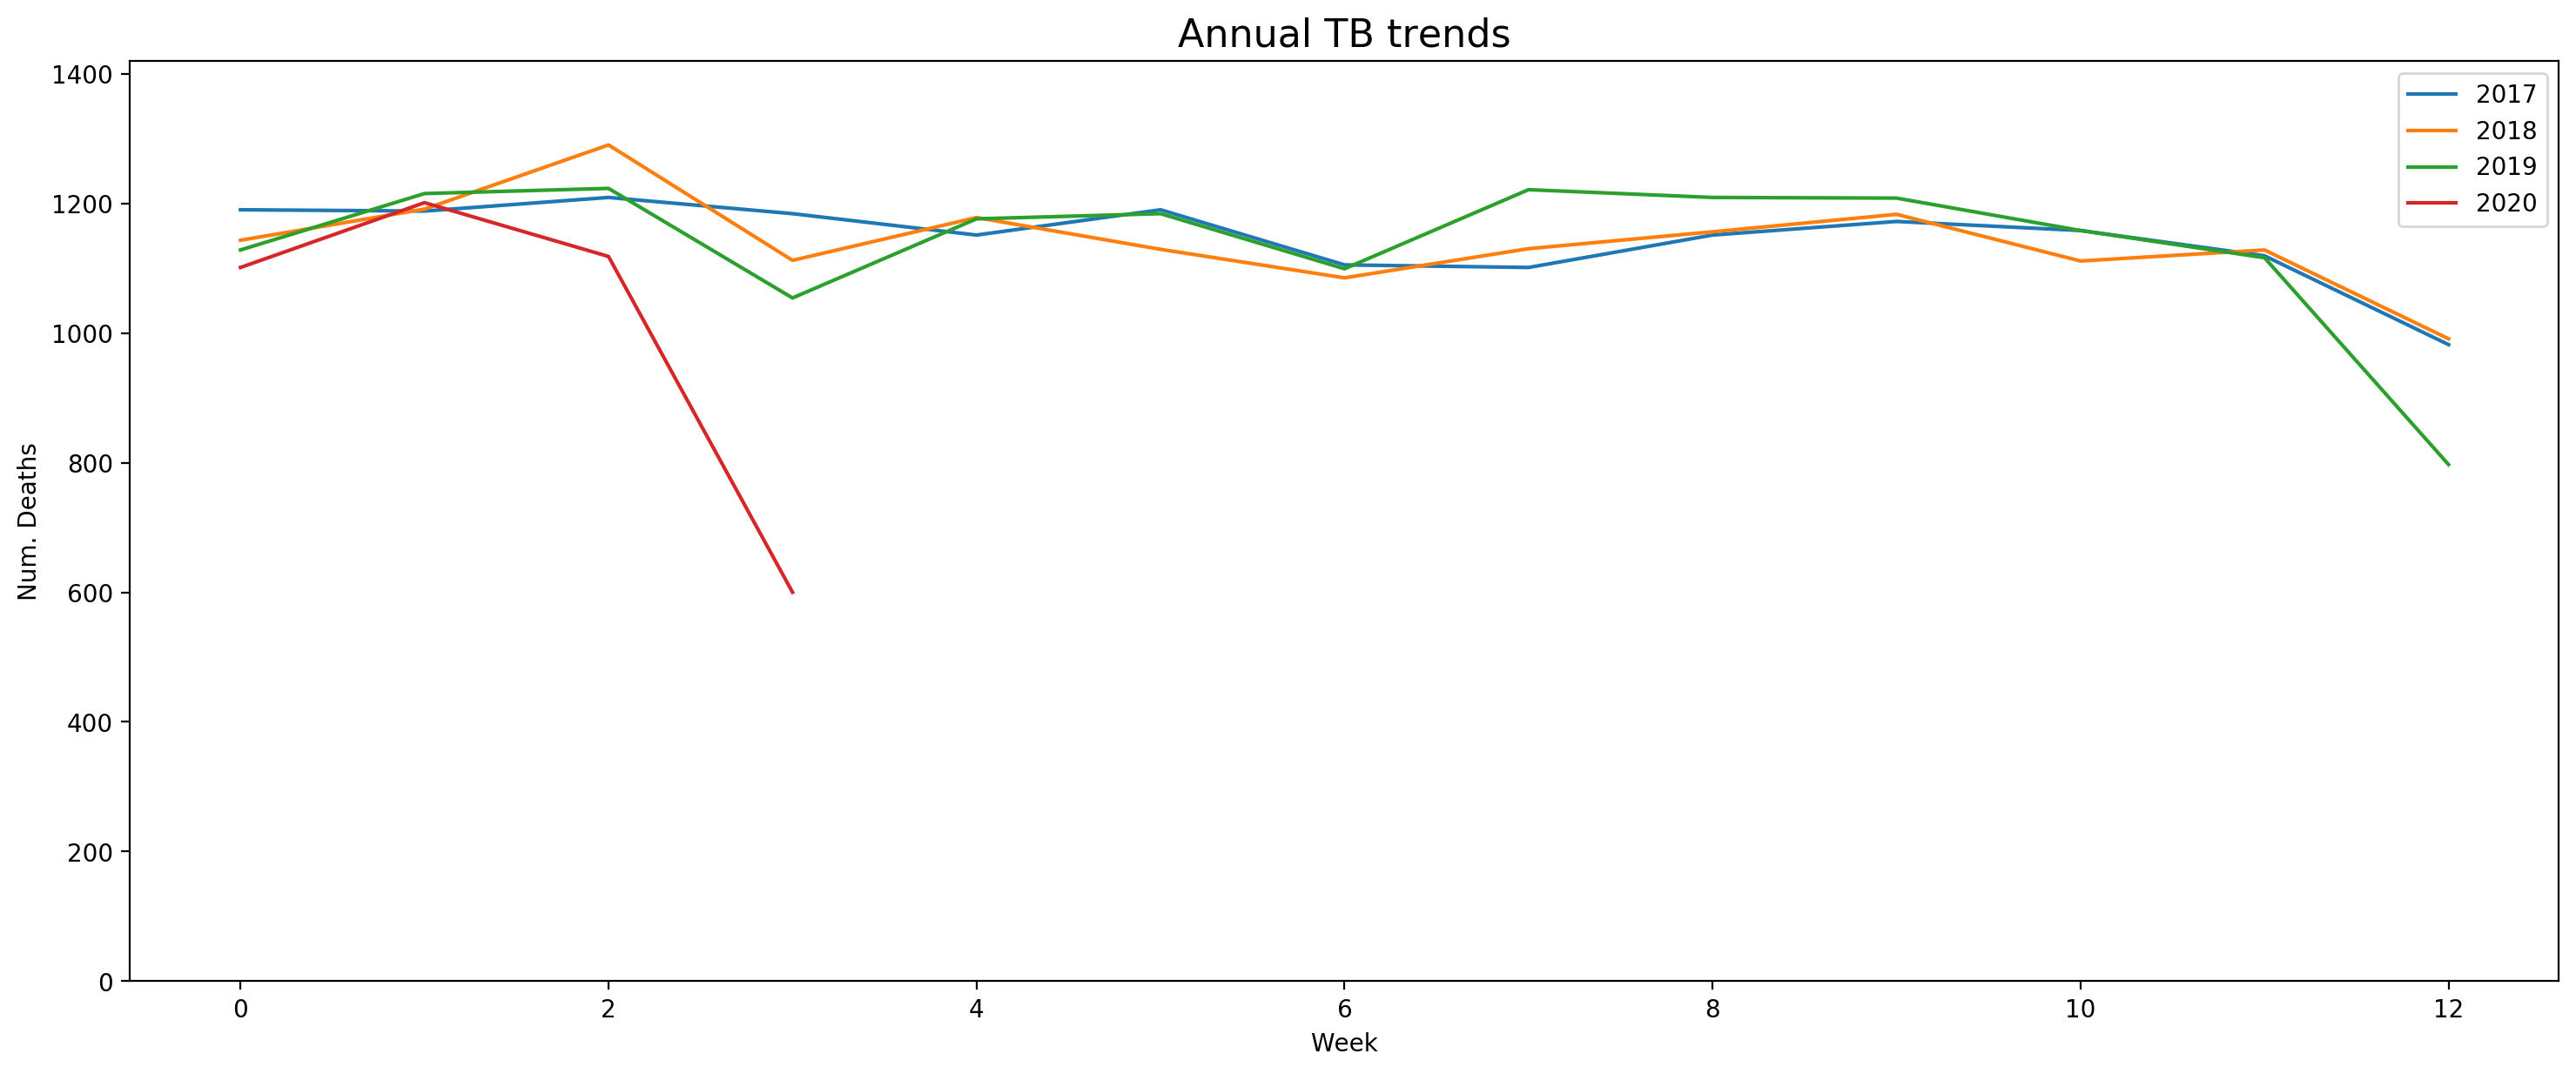

In [16]:
# Plot trends by year
plt.figure(figsize=(18, 7), dpi=200)
plt.plot(range(len(data_2017)), data_2017, label='2017')
plt.plot(range(len(data_2018)), data_2018, label='2018')
plt.plot(range(len(data_2019)), data_2019, label='2019')
plt.plot(range(len(data_2020)), data_2020, label='2020')
plt.ylim((0, max_y))
plt.title('Annual TB trends', fontsize=16)
plt.xlabel('Week', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.xticks(fontsize=10)
plt.legend()
plt.show()

### 1.3. Check Month-wise (seasonal) and Year-wise (trend) distribution

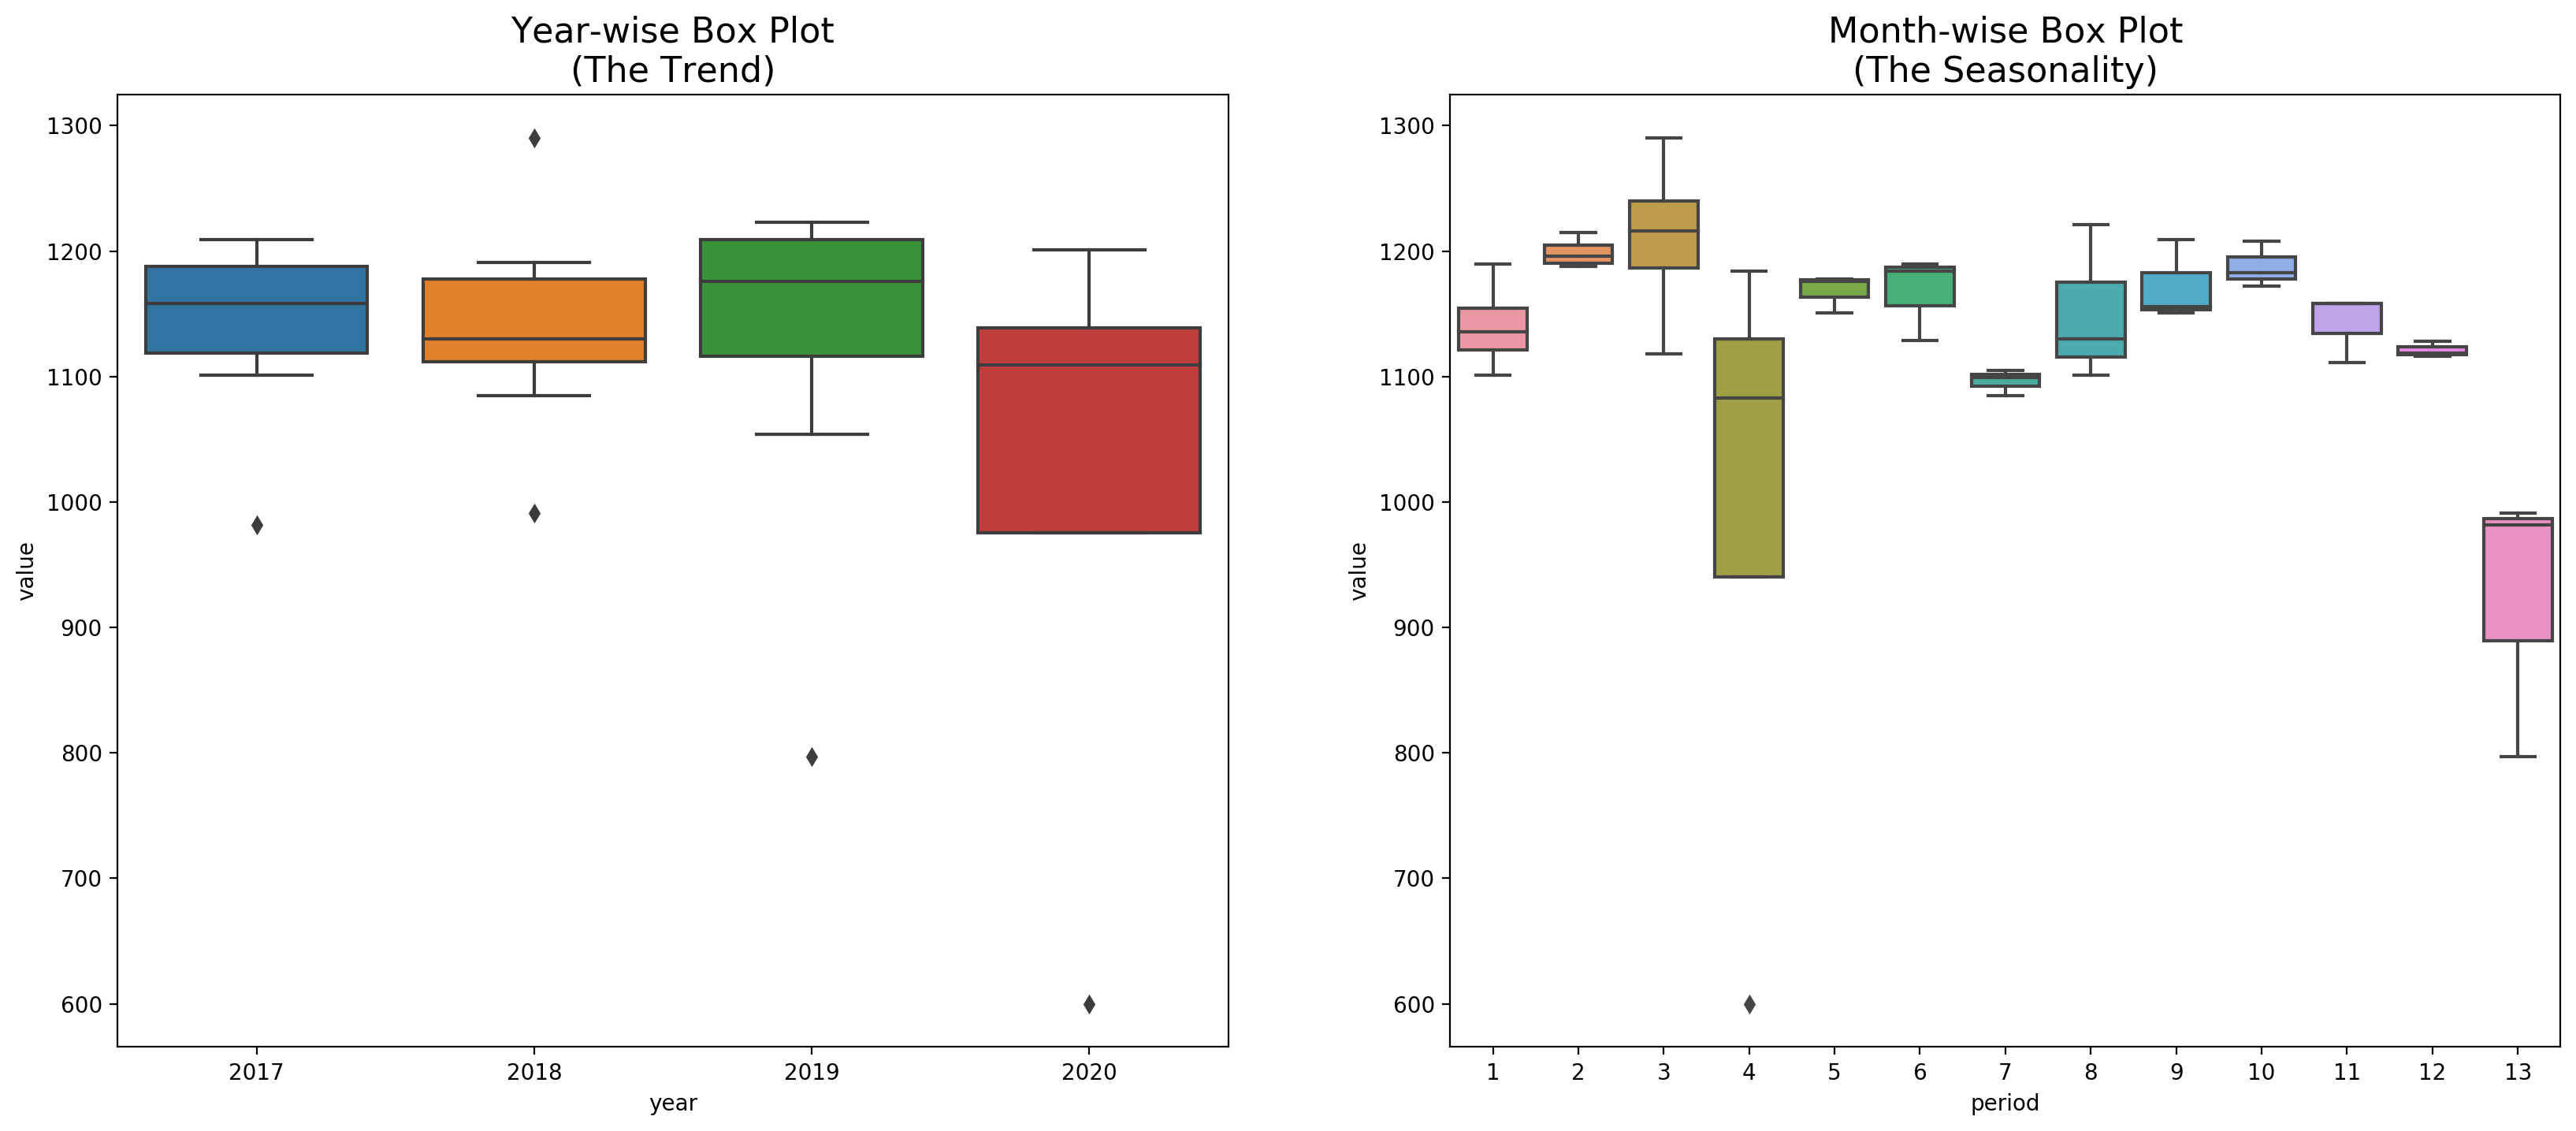

In [17]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi= 200)
sns.boxplot(x='year', y='value', data=dataset, ax=axes[0])
sns.boxplot(x='period', y='value', data=dataset, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=16); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=16)
plt.show()

#### Result
The dataset contains an obvious trend but no obvious seasonal component.

## 2. Base Line

The error validation functions are defined:

In [18]:
# Calculate root mean squared error or RMSE
def calc_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [19]:
# Calculate mean absolute percentage error or MAPE
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def calc_mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [20]:
# Calculate confidence interval
def get_interval(y, y_pred, pi=0.99):
    n = len(y)
    
    # Get standard deviation of y_test
    sum_errs = np.sum((y - y_pred)**2) / (n - 2)
    stdev = np.sqrt(sum_errs)
    
    # Get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    return interval

In [21]:
# Calculate AIC for regression
def calc_aic(actual, predicted, k=1):
    n = len(actual)
    mse = mean_squared_error(actual, predicted)
    aic = n * log(mse) + 2 * k
    return aic

In [22]:
# Calculate BIC for regression
def calc_bic(actual, predicted, k=1):
    n = len(actual)
    mse = mean_squared_error(actual, predicted)
    bic = n * log(mse) + k * log(n)
    return bic

### 2.1. Linear Regression

In [23]:
# Create model LR
degree = 3
x_ = PolynomialFeatures(degree=degree, include_bias=True).fit_transform(x_data)
model = LinearRegression().fit(x_, y_data)

# Validate model
r_sq = model.score(x_, y_data)
print('Correlation:', sqrt(r_sq))
print('Coefficient of determination:', r_sq)
print('Intercept:', model.intercept_, ', Slope:', model.coef_)

Correlation: 0.525263645826437
Coefficient of determination: 0.27590189762688067
Intercept: 1232.3071054325146 , Slope: [  0.         -24.23165588   1.55999     -0.02757557]


In [24]:
# Validation
y_pred = model.predict(x_)
k = len(model.coef_) + 1

# Calculate errors
rmse = calc_rmse(y_data, y_pred)
mape = calc_mape(y_data, y_pred)
aic = calc_aic(y_data, y_pred, k)
bic = calc_bic(y_data, y_pred, k)
print('Number of parameters: %d' % (k))
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))
print('The AIC of our forecasts is: {}'.format(round(aic, 3)))
print('The BIC of our forecasts is: {}'.format(round(bic, 3)))

Number of parameters: 5
The RMSE of our forecasts is: 96.32
The MAPE of our forecasts is: 6.723 %
The AIC of our forecasts is: 402.82
The BIC of our forecasts is: 411.626


In [25]:
ci_alpha = 0.9
ci = get_interval(y_data, y_pred, ci_alpha)
print('Conf. Int.:', ci)

Conf. Int.: 162.24976529753405


In [26]:
# Prediction
periods = 52
x_date2 = pd.date_range(start='2017-01-01', end='2020-12-27', periods=periods)
x_ = PolynomialFeatures(degree=degree, include_bias=True).fit_transform(np.array(range(13 * 4)).reshape((-1, 1)))
y_pred = model.predict(x_)

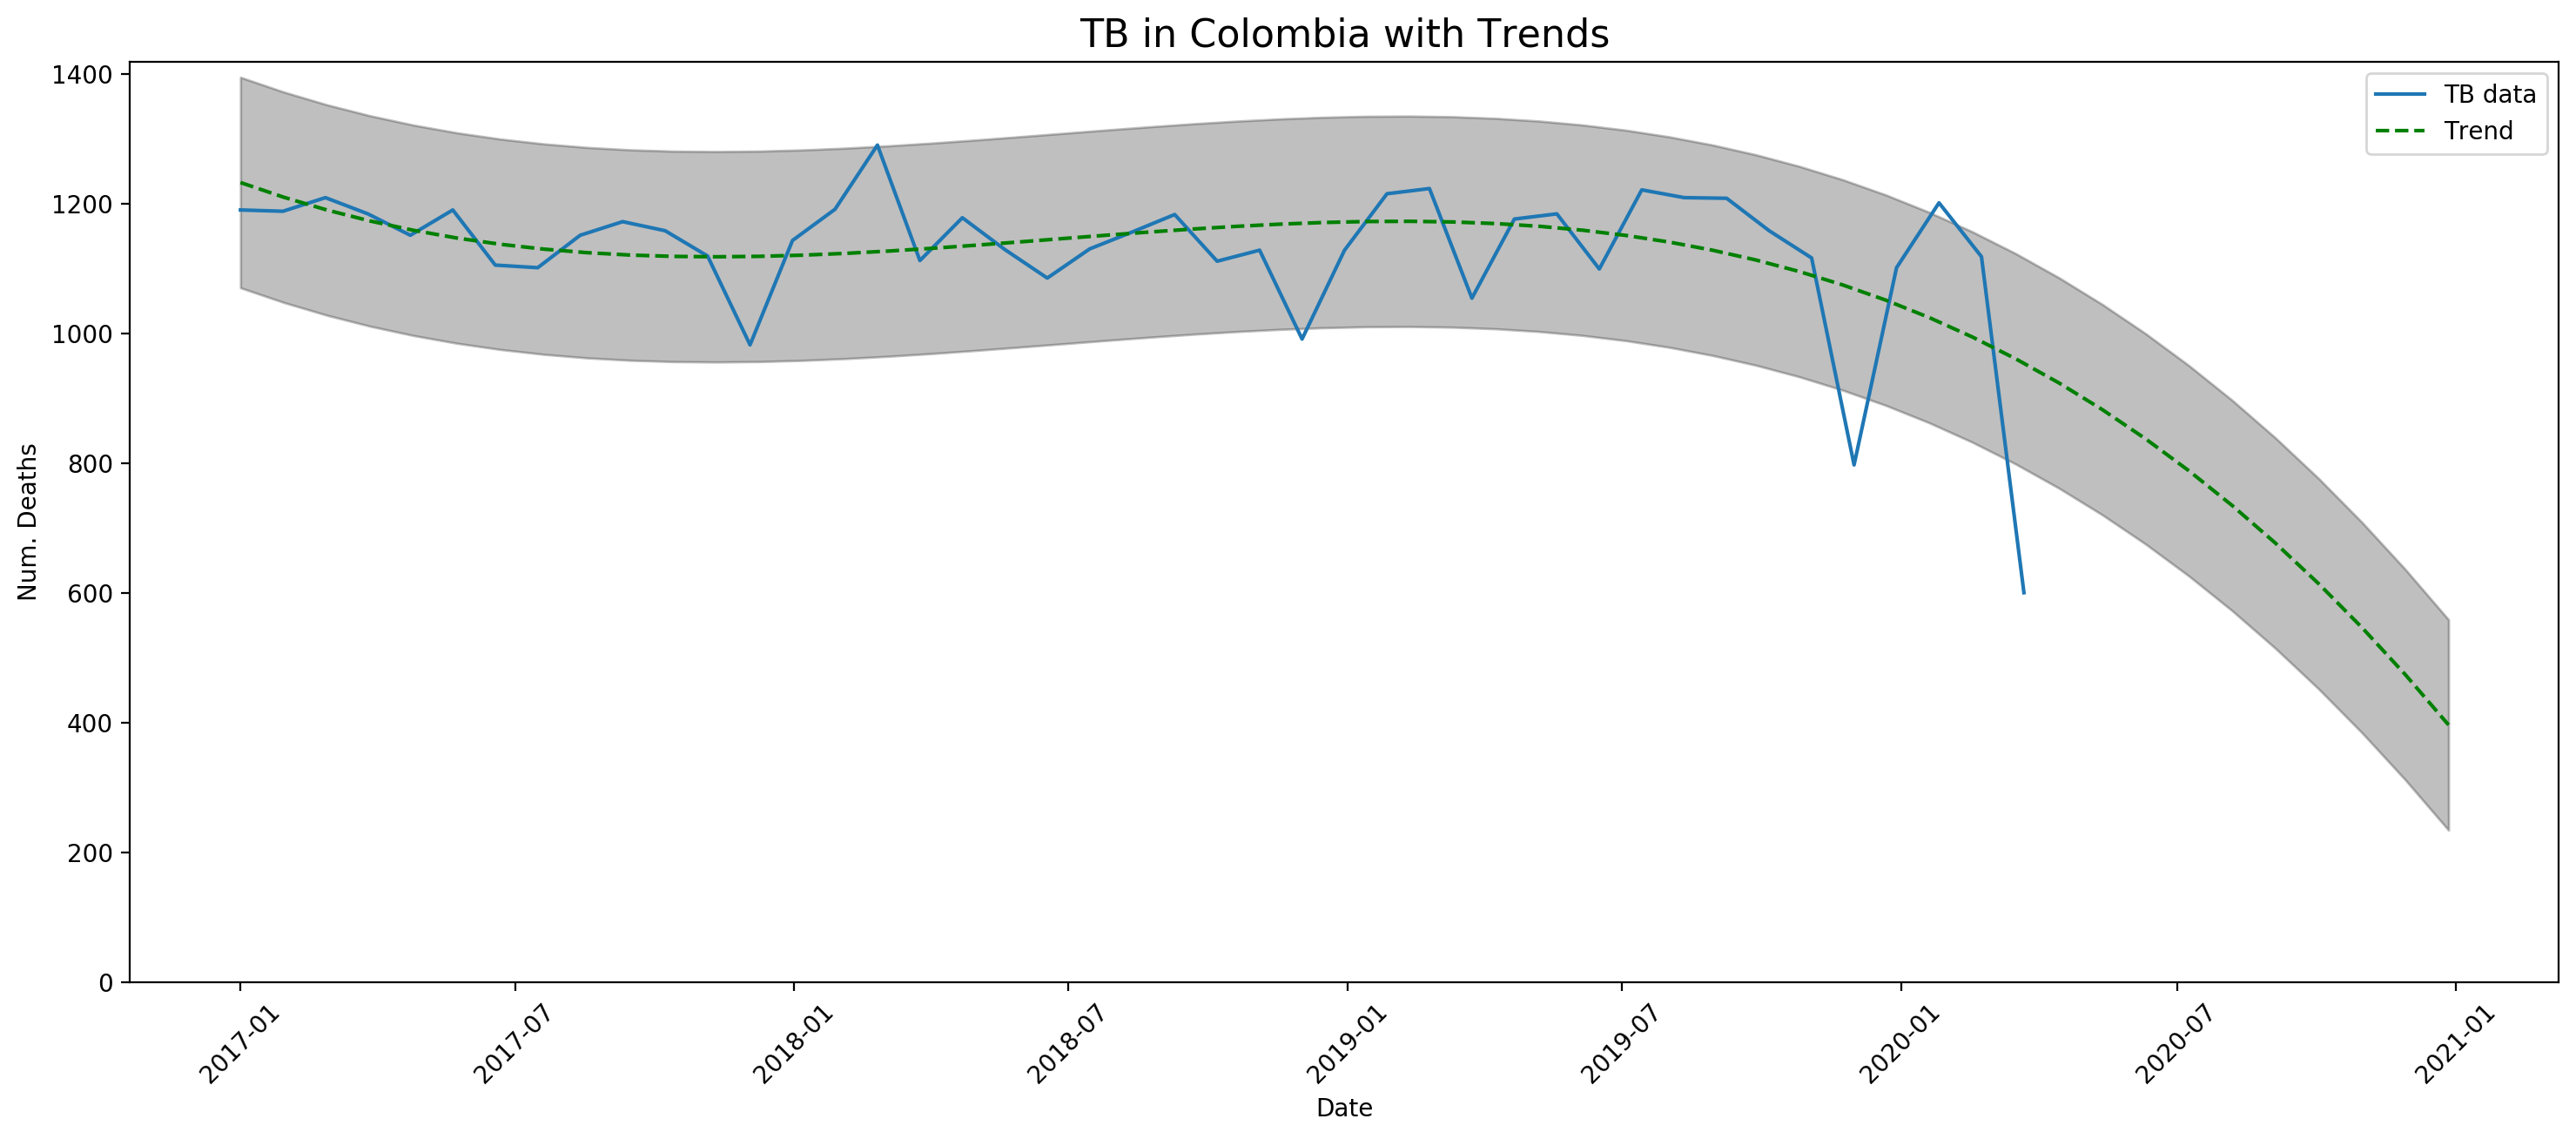

In [27]:
# Plot chart
plt.figure(figsize=(18, 7), dpi=200)
plt.plot(x_date, y_data, '-', label='TB data')
plt.plot(x_date2, y_pred, '-', color='green', label='Trend', linestyle='dashed')
plt.fill_between(x_date2, y_pred - ci, y_pred + ci, color='k', alpha=.25)
plt.ylim((0, max_y))
plt.title('TB in Colombia with Trends', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.xticks(fontsize=10, rotation=45)
plt.legend()
plt.show()

#### Result
- RMSE: 96.32
- MAPE: 6.723 %
- AIC: 402.82
- BIC: 411.626

## 3. Time Series Analysis

In [28]:
# Control param for SARIMA and Holt-Winters methods
perc_test = 0.20 # 20%
data_freq = 13
n_forecast = 13
run_fit = False

In [29]:
# Cooking time-series data with frequency
filter_date = pd.to_datetime('2020-01-01').date()
series_data = dataset['value']
series_data = series_data.loc[series_data.index < filter_date]
series_data = series_data.asfreq(freq='4W')
series_data

date
2017-01-01    1190
2017-01-29    1188
2017-02-26    1209
2017-03-26    1184
2017-04-23    1151
2017-05-21    1190
2017-06-18    1105
2017-07-16    1101
2017-08-13    1151
2017-09-10    1172
2017-10-08    1158
2017-11-05    1119
2017-12-03     982
2017-12-31    1143
2018-01-28    1191
2018-02-25    1290
2018-03-25    1112
2018-04-22    1178
2018-05-20    1129
2018-06-17    1085
2018-07-15    1130
2018-08-12    1156
2018-09-09    1183
2018-10-07    1111
2018-11-04    1128
2018-12-02     991
2018-12-30    1128
2019-01-27    1215
2019-02-24    1223
2019-03-24    1054
2019-04-21    1176
2019-05-19    1184
2019-06-16    1099
2019-07-14    1221
2019-08-11    1209
2019-09-08    1208
2019-10-06    1158
2019-11-03    1116
2019-12-01     797
2019-12-29    1101
Freq: 4W-SUN, Name: value, dtype: int64

### 3.1. Statistical tests for stationarity

In a stationary **time series**, statistical properties such as mean and variance are constant over time. In a non-stationary series, these properties are dependent on time.

Augmented Dickey-Fuller unit root test:
- Tests for trend non-stationarity.
- Null hypothesis ($H_0$) is time series is non-stationary.

In [30]:
adf_results = adfuller(series_data)
print('ADF Statistic:', adf_results[0])
print('p-value:', adf_results[1])

ADF Statistic: -4.863745335534495
p-value: 4.100695860793238e-05


In [31]:
adf_results = adfuller(series_data.diff().dropna())
print('ADF Statistic:', adf_results[0])
print('p-value:', adf_results[1])

ADF Statistic: -2.1530591776112993
p-value: 0.22372094988827318


#### Result
- Based on ADF test statistic and p-value the time series is non-stationary. We fail to reject the null hypothesis.
- However, the first difference in the time series itself is stationary.

### 3.2. Correlation and autocorrelation

C:\Users\Andres\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


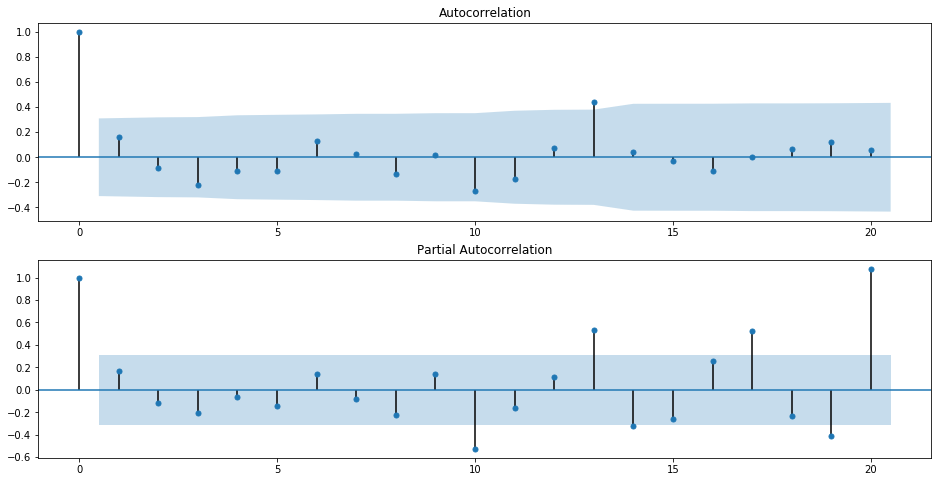

In [32]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
plot_acf(series_data, lags=20, ax=ax1)
plot_pacf(series_data, lags=20, ax=ax2)
plt.show()

#### Result
We can use a $p = 3$.

### 3.3. Check seasonal decomposition

These components are defined as follows:
- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

#### 3.3.1. Additive decomposition
Additive series = Level + Trend + Seasonality + Noise

In [33]:
# Additive Decomposition
# result_add = seasonal_decompose(series_data, model='additive', extrapolate_trend='freq')

# Show Additive Decompose
# plt.rcParams.update({'figure.figsize': (12, 10)})
# result_add.plot()
# plt.show()

#### 3.3.2. Multiplicative decomposition
Multiplicative series = Level x Trend x Seasonality x Noise

In [34]:
# Multiplicative Decomposition
# result_add = seasonal_decompose(series_data, model='multiplicative', extrapolate_trend='freq')

# Show Additive Decompose
# plt.rcParams.update({'figure.figsize': (12, 10)})
# result_add.plot()
# plt.show()

#### Result
Both the additive and multiplicative models have the following properties:
- Clear decreasing trend.
- It's a seasonal time series.
- The residuals oscillate around 0

## 4. Box-Jenkins Analysis

In time series analysis, the Box–Jenkins method, applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series.

### 4.1. Select best parameters for SARIMA model

AIC - Akaike information criterion
- Lower AIC indicates a better model
- AIC likes to choose simple models with lower order

BIC - Bayesian information criterion
- Very similar to AIC
- Lower BIC indicates a better model
- BIC likes to choose simple models with lower order

In [35]:
# Create a set of SARIMA configs to try
def arima_smoothing_configs():
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 3)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq  = [(x[0], x[1], x[2], data_freq) for x in list(itertools.product(p, d, q))]
    
    return pdq, seasonal_pdq

In [36]:
# Parameter Selection for the ARIMA Time Series Model
def arima_grid_search(pdq, seasonal_pdq):
    start_time = timeit.default_timer()
    
    # Specify to ignore warning messages
    filterwarnings("ignore")
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                
                if results.aic > 0 or results.bic > 0:
                    print('SARIMA: {} x {}, AIC:{}, BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
            except:
                # Print AIC and BIC as None when fails
                print('Error: SARIMA: {} x {}, AIC:{}, BIC:{}'.format(param, param_seasonal, None, None))
    
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    print('Elapsed time', elapsed, 's')

#### Run the grid search

In [37]:
# Run ARIMA fit
if run_fit:
    
    # Calculation params
    pdq, seasonal_pdq = arima_smoothing_configs()
    
    # Run grid search
    arima_grid_search(pdq, seasonal_pdq)
    print('Done SARIMA method')

### 4.2. Create SARIMA model

- Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
- Prob(JB) - p-value for null hypothesis that residuals are normal

In [38]:
# Fitting a SARIMA Time Series model
filterwarnings("ignore")
model = sm.tsa.statespace.SARIMAX(series_data, order=(2, 1, 2), seasonal_order=(2, 0, 1, data_freq), 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

In [39]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                   40
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 13)   Log Likelihood                 -55.006
Date:                              Wed, 09 Sep 2020   AIC                            126.013
Time:                                      10:48:59   BIC                            129.196
Sample:                                  01-01-2017   HQIC                           124.006
                                       - 12-29-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6731      0.260     -2.588      0.010      -1.183      -0.163
ar.L2         -0.82

#### Plot diagnostics

If the model fits well the residuals will be white Gaussian noise.

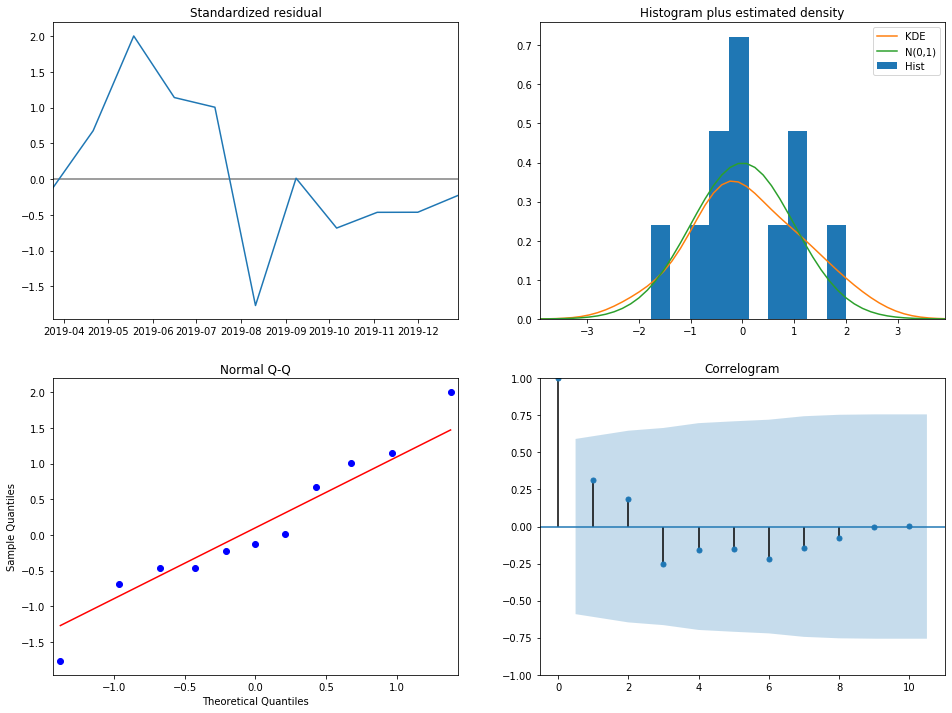

In [40]:
model.plot_diagnostics(figsize=(16, 12))
plt.show()

### 4.3. Validating SARIMA forecasts

In [41]:
# Start prediction from...
ix_test = ceil(len(series_data) * (1 - perc_test))
start_date = series_data.index[ix_test]
ix_test, start_date

(32, Timestamp('2019-06-16 00:00:00', freq='4W-SUN'))

#### 4.3.1. Validate prediction with dynamic False

In [42]:
# Validate prediction with dynamic False
pred = model.get_prediction(start=start_date, dynamic=False)
pred_ci = pred.conf_int(alpha=1-ci_alpha)

# Show predictions
y_forecasted = pd.Series(np.array([round(p) for p in pred.predicted_mean]), pred.predicted_mean.index)
y_forecasted

date
2019-06-16    1057
2019-07-14    1186
2019-08-11    1269
2019-09-08    1208
2019-10-06    1181
2019-11-03    1131
2019-12-01     812
2019-12-29    1108
Freq: 4W-SUN, dtype: int32

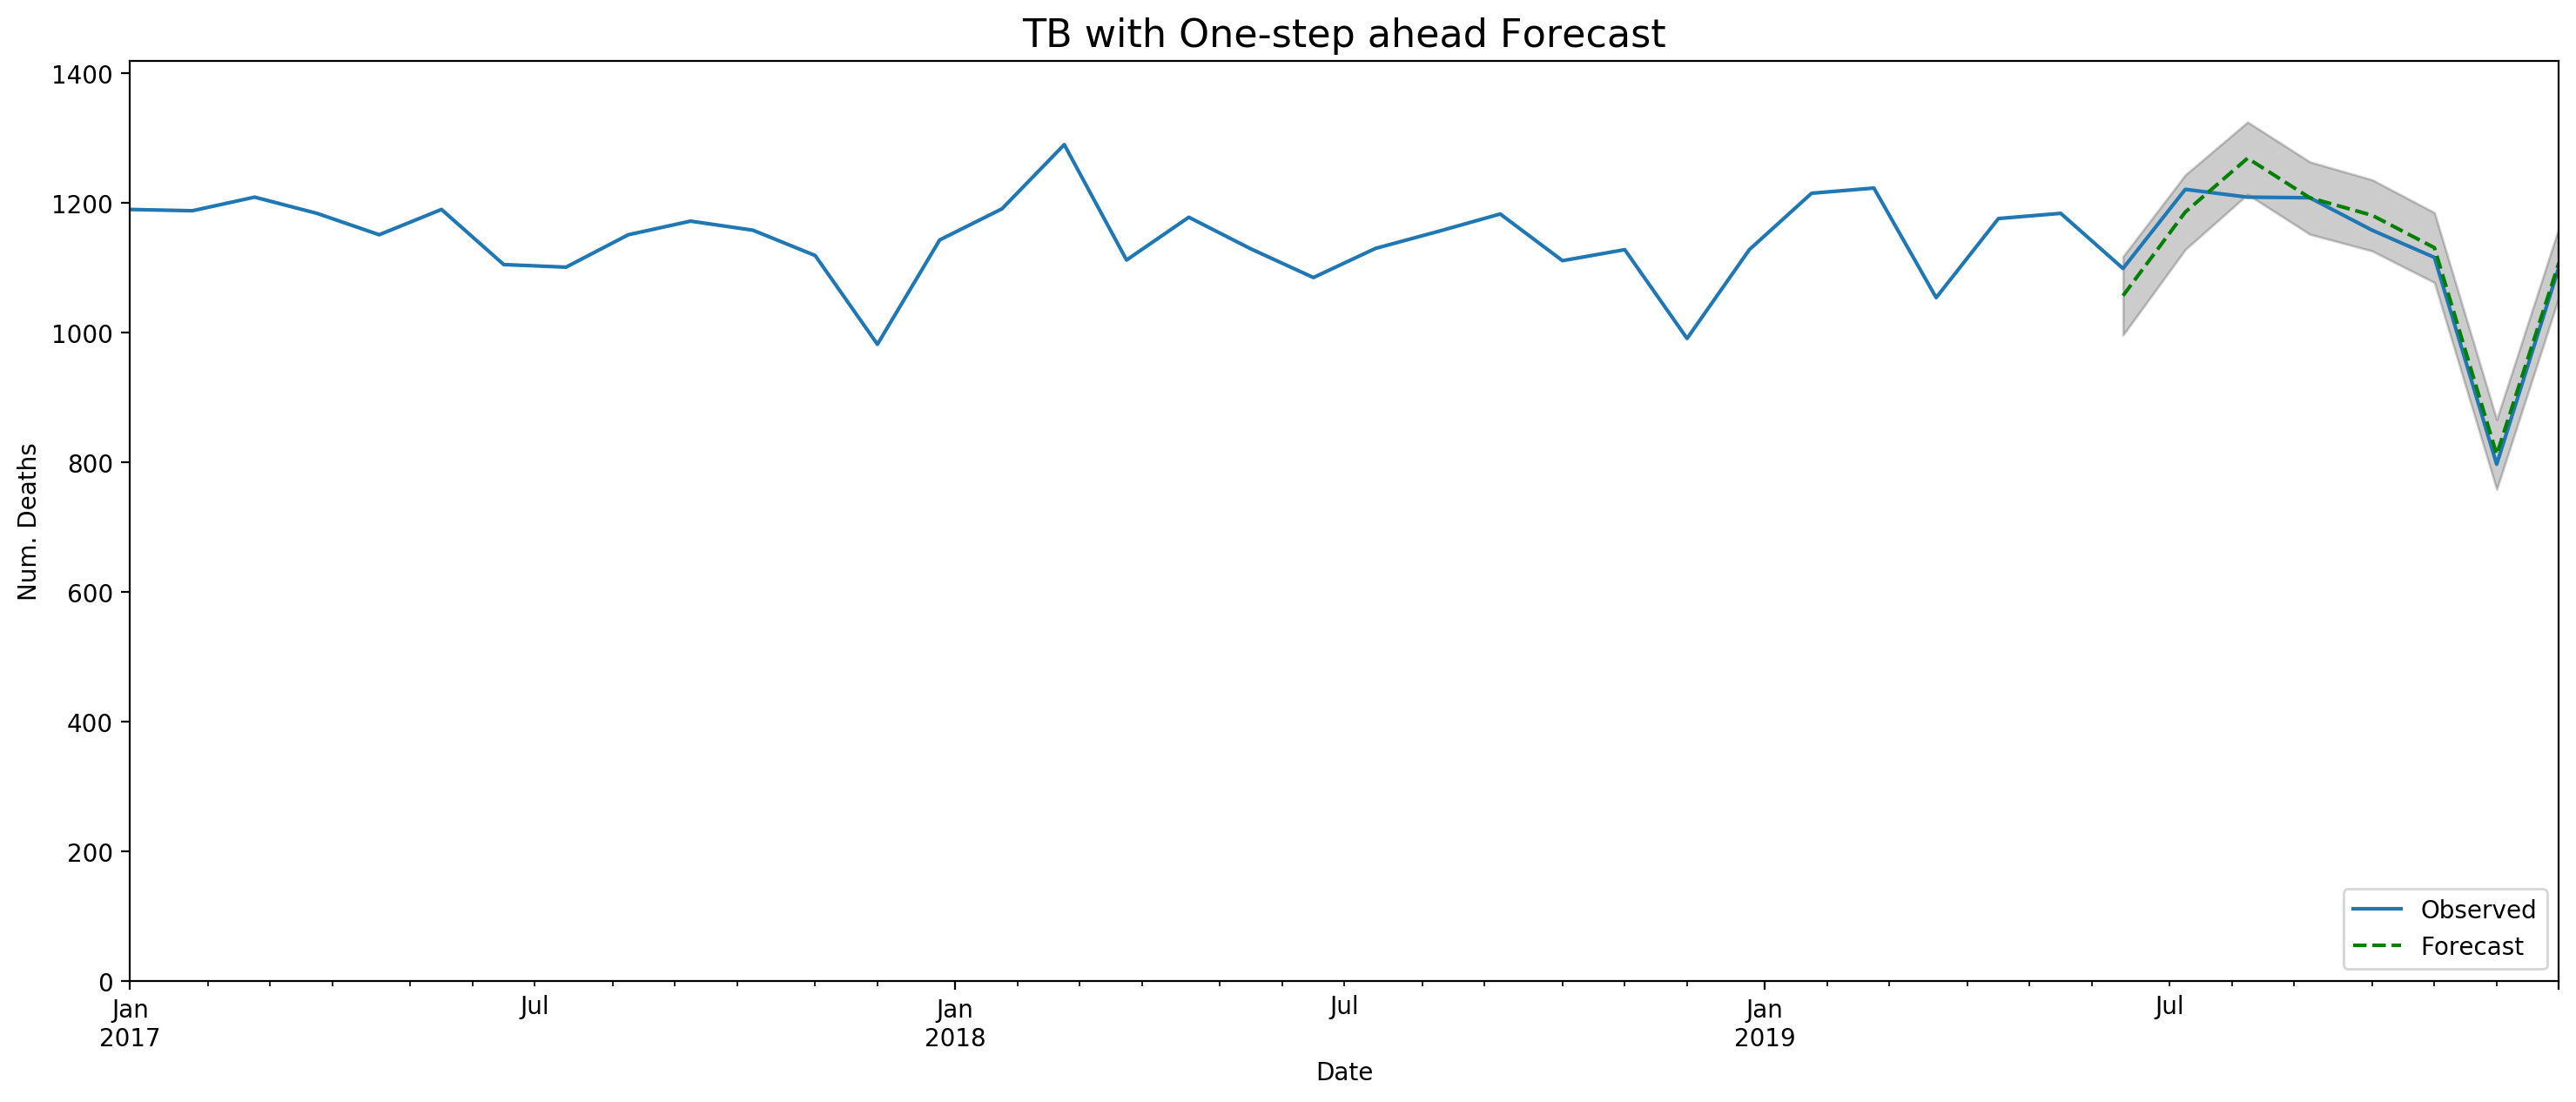

In [43]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
y_forecasted.plot(ax=ax, label='Forecast', color='green', linestyle='dashed')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.ylim((0, max_y))
plt.title('TB with One-step ahead Forecast', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.legend(loc='lower right')
plt.show()

In [44]:
# Extract the predicted and true values of our time series
y_truth = series_data[start_date:]

# Compute the errors
rmse = calc_rmse(y_truth, y_forecasted)
mape = calc_mape(y_truth, y_forecasted)
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))

The RMSE of our forecasts is: 30.857
The MAPE of our forecasts is: 2.187 %


#### 4.3.2. Validate prediction with dynamic True

In [45]:
# Predict
pred_dynamic = model.get_prediction(start=start_date, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int(alpha=1-ci_alpha)

# Show predictions
y_forecasted = pd.Series(np.array([round(p) for p in pred_dynamic.predicted_mean]), pred_dynamic.predicted_mean.index)
y_forecasted

date
2019-06-16    1057
2019-07-14    1133
2019-08-11    1184
2019-09-08    1212
2019-10-06    1160
2019-11-03    1134
2019-12-01     855
2019-12-29    1155
Freq: 4W-SUN, dtype: int32

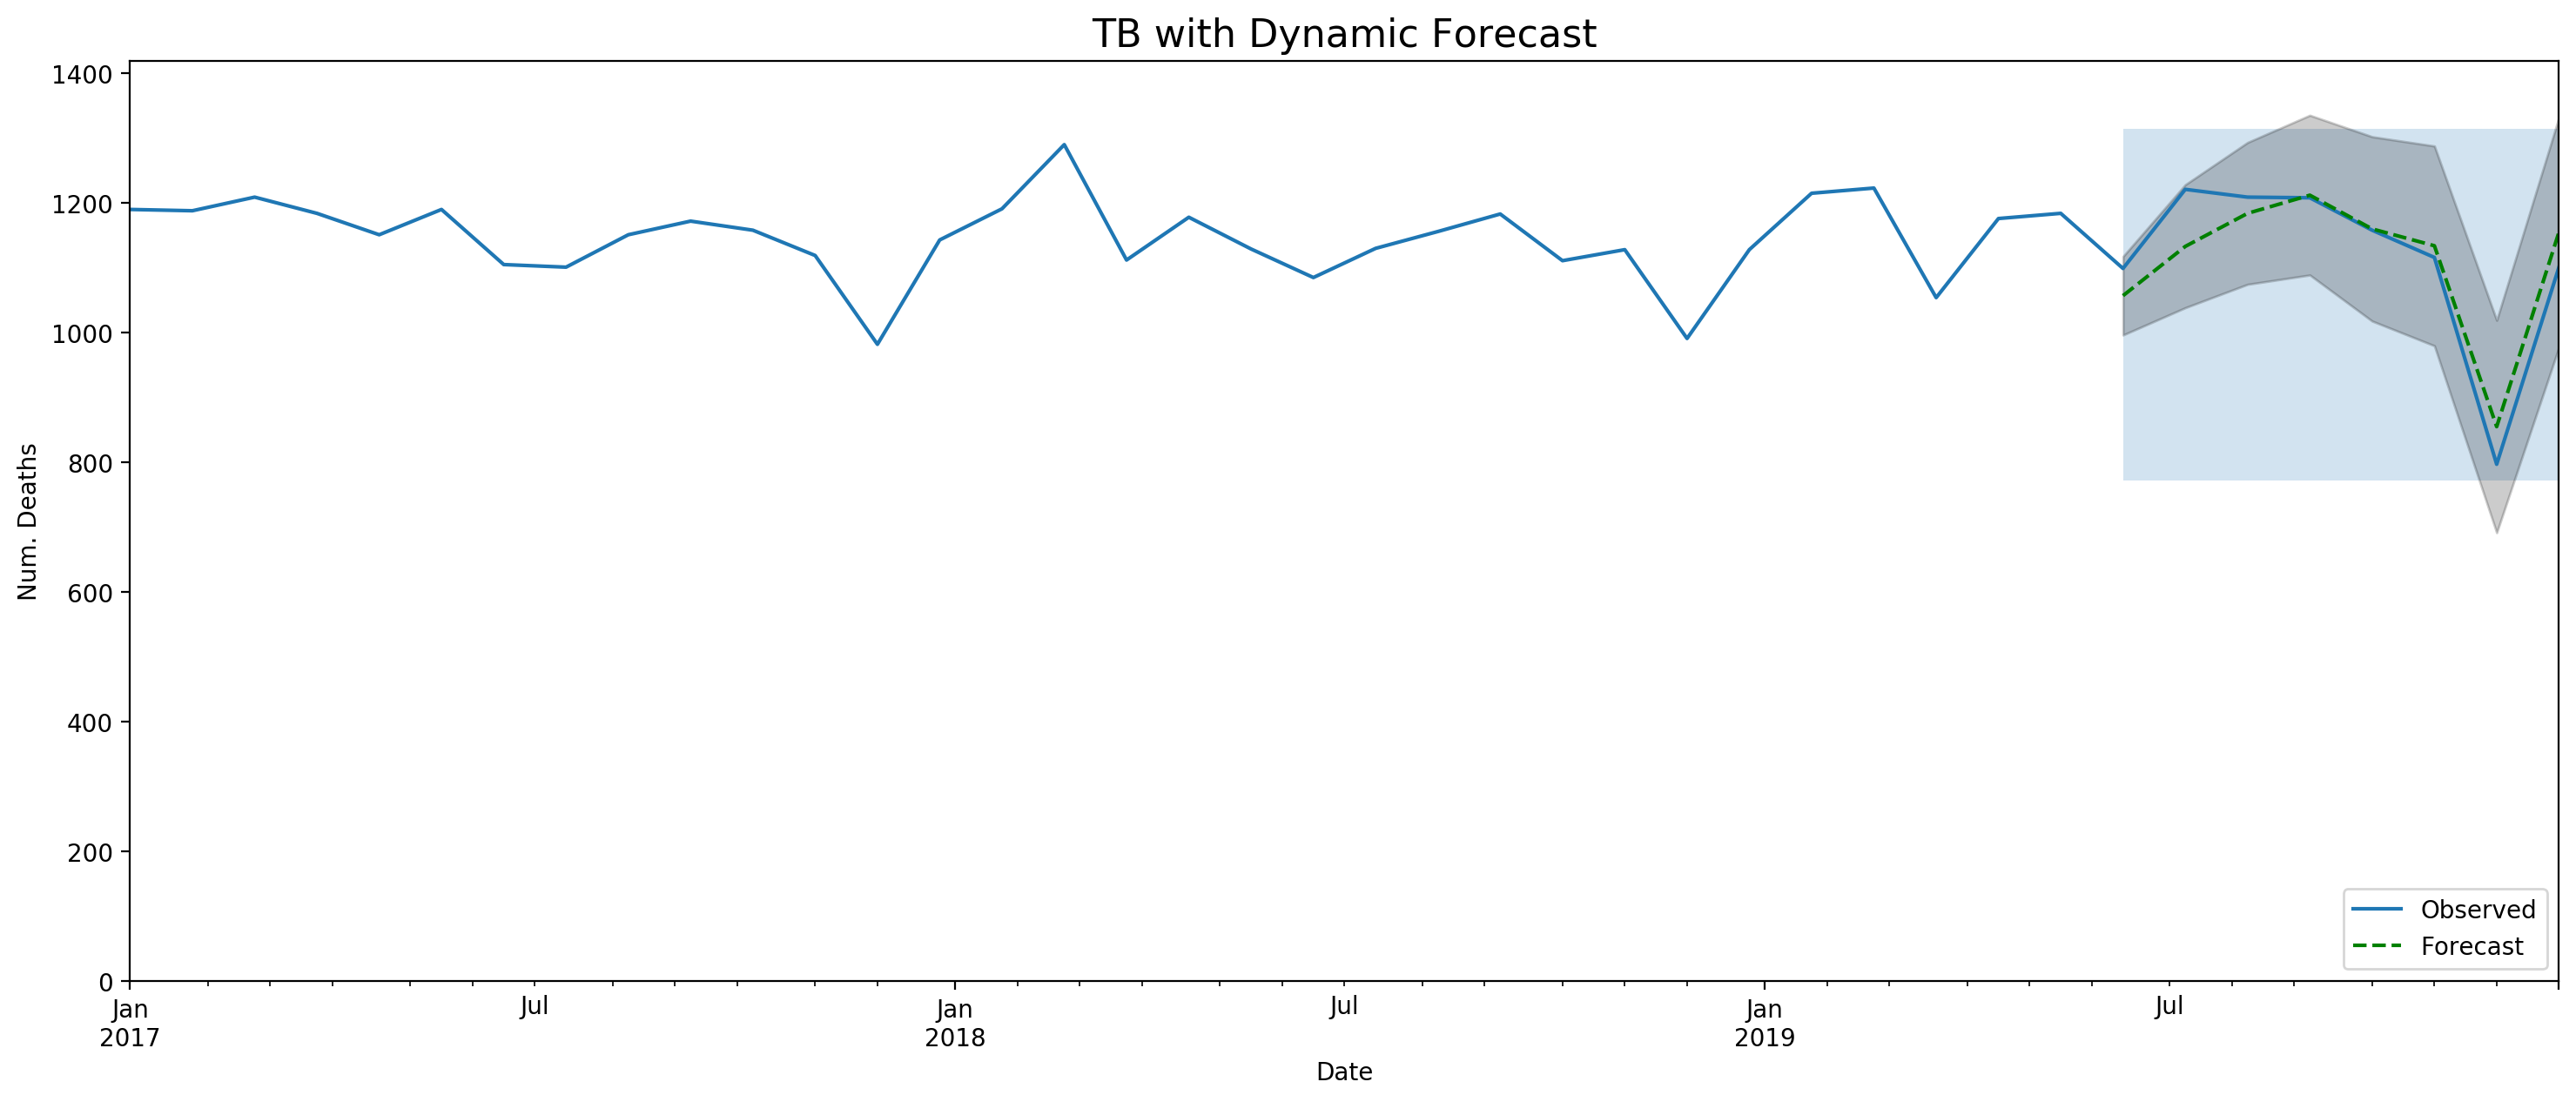

In [46]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
y_forecasted.plot(ax=ax, label='Forecast', color='green', linestyle='dashed')
ax.fill_betweenx(ax.get_ylim(), pred_dynamic_ci.index[0], pred_dynamic_ci.index[-1], alpha=.2, zorder=-1)
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
plt.ylim((0, max_y))
plt.title('TB with Dynamic Forecast', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.legend(loc='lower right')
plt.show()

In [47]:
# Extract the predicted and true values of our time series
y_truth = series_data[start_date:]

# Compute the errors
rmse = calc_rmse(y_truth, y_forecasted)
mape = calc_mape(y_truth, y_forecasted)
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))

The RMSE of our forecasts is: 45.767
The MAPE of our forecasts is: 3.424 %


### 4.4. Producing and visualizing forecasts

In [48]:
# Get forecast n steps ahead in future (1 year)
pred_bj = model.get_forecast(steps=n_forecast)
y_forecasted = np.array([max(round(p),0) for p in pred_bj.predicted_mean])

# Get confidence intervals of forecasts
pred_df = pd.DataFrame(y_forecasted, columns=['forecast'])
pred_df = pred_df.set_index(pred_bj.predicted_mean.index)
pred_ci = pred_bj.conf_int(alpha=1-ci_alpha)
pred_df['ci_inf'] = pred_ci.iloc[:, 0]
pred_df['ci_sup'] = pred_ci.iloc[:, 1]
pred_df

,forecast,ci_inf,ci_sup
2020-01-26,1247,1197.716335,1295.978950
2020-02-23,1316,1230.962783,1401.642211
2020-03-22,999,894.036446,1103.221185
2020-04-19,1190,1074.029434,1305.668852
2020-05-17,1106,973.448498,1238.712725
2020-06-14,968,820.756049,1114.828390
2020-07-12,1138,982.371585,1294.283881
2020-08-09,1156,988.349150,1323.030171
2020-09-06,1176,996.947749,1355.489695
2020-10-04,1080,892.965270,1267.824786


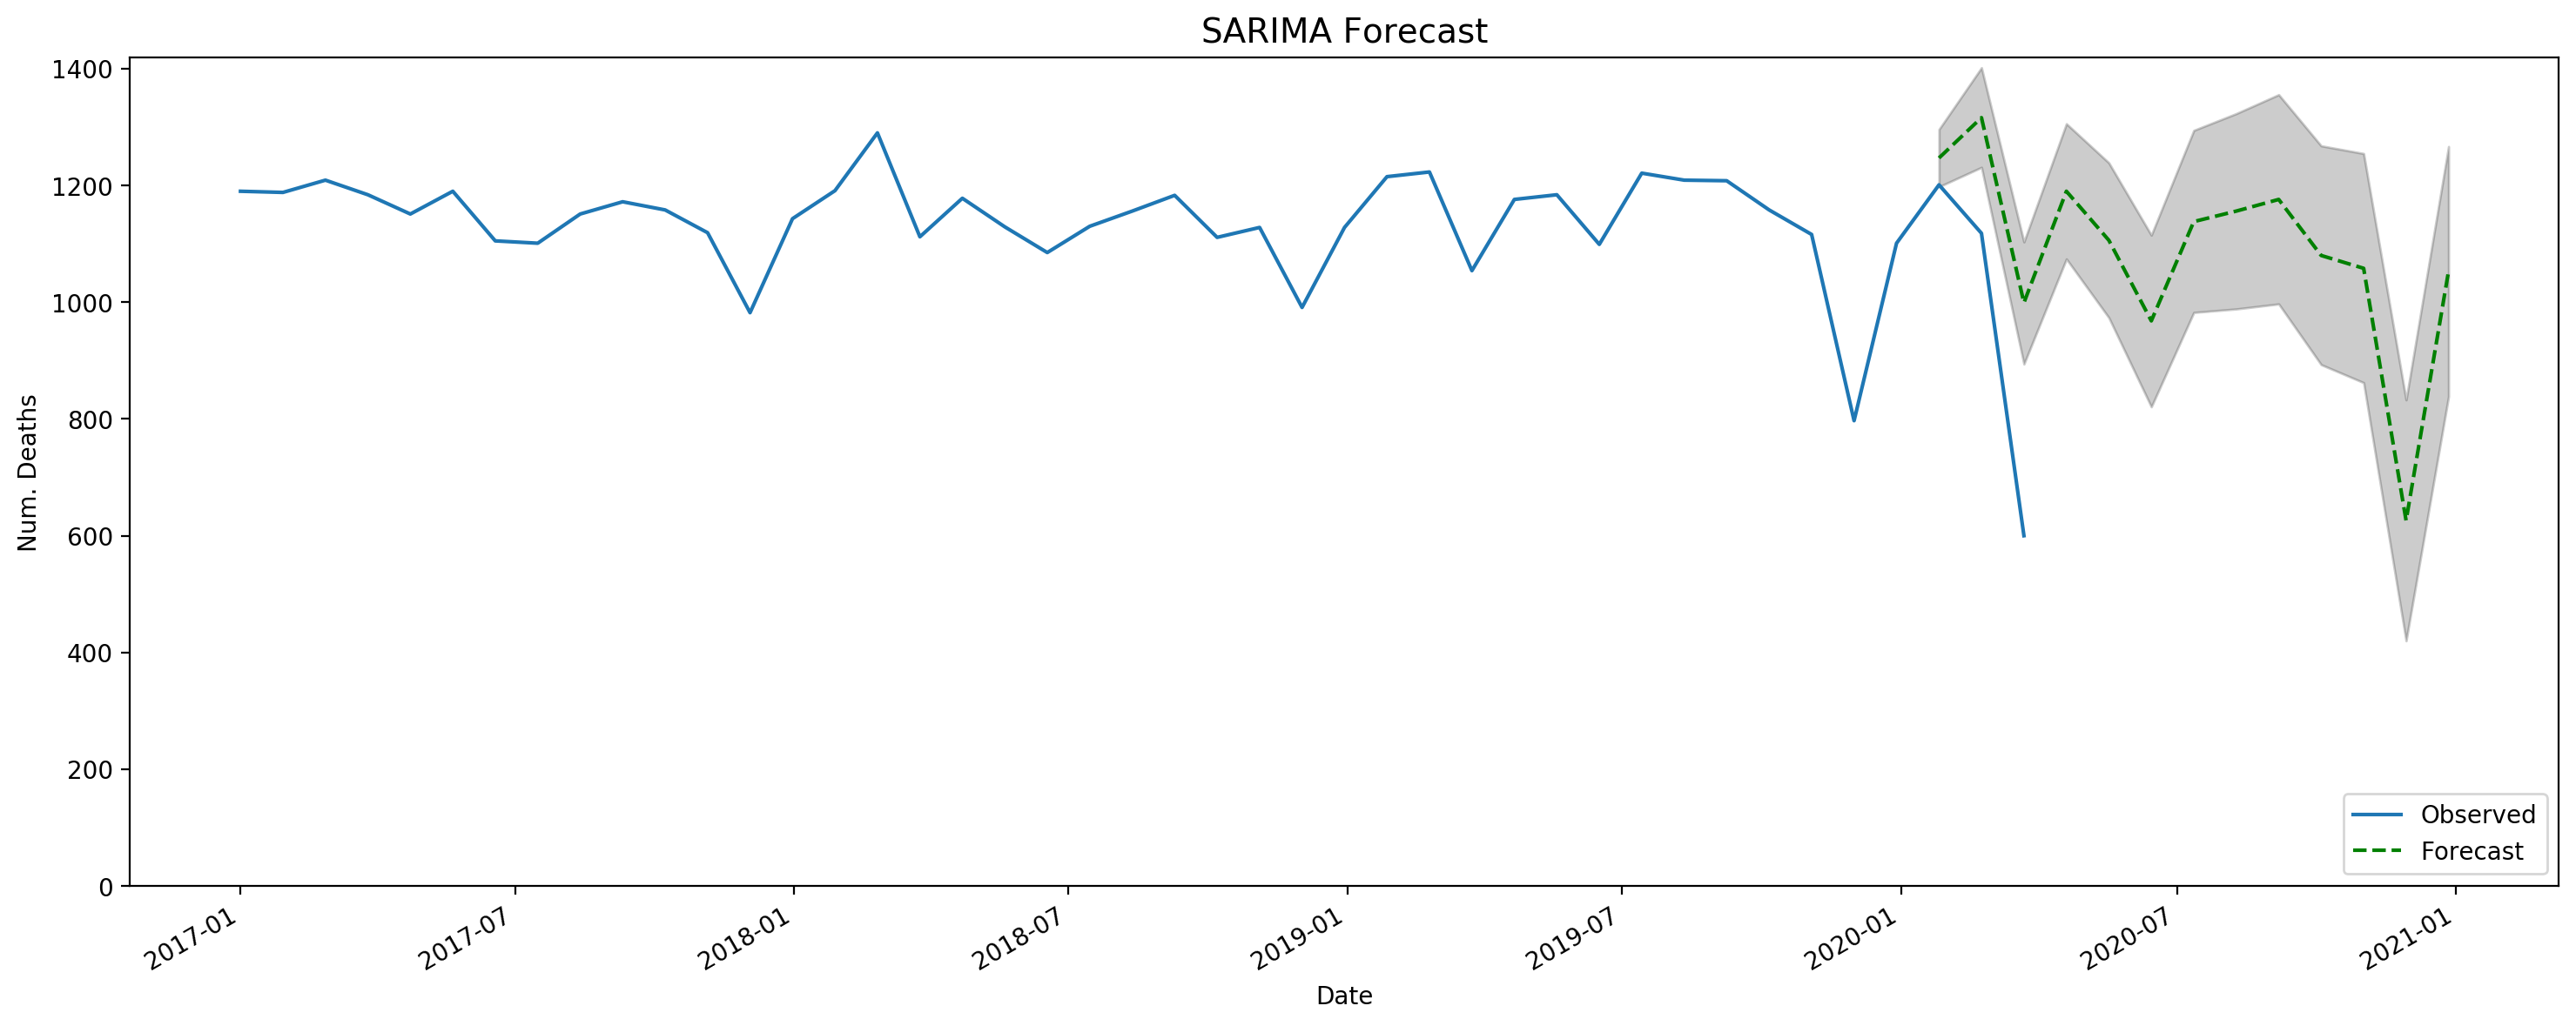

In [49]:
# Plot ARIMA results
plt.figure(figsize=(18, 7), dpi=200)
ax = dataset['value'].plot(label='Observed')
pred_df.forecast.plot(ax=ax, label='Forecast', color='green', linestyle='dashed')
ax.fill_between(pred_ci.index, pred_df.ci_inf, pred_df.ci_sup, color='k', alpha=.2)
plt.ylim((0, max_y))
plt.title('SARIMA Forecast', fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.legend(loc='lower right')
plt.show()

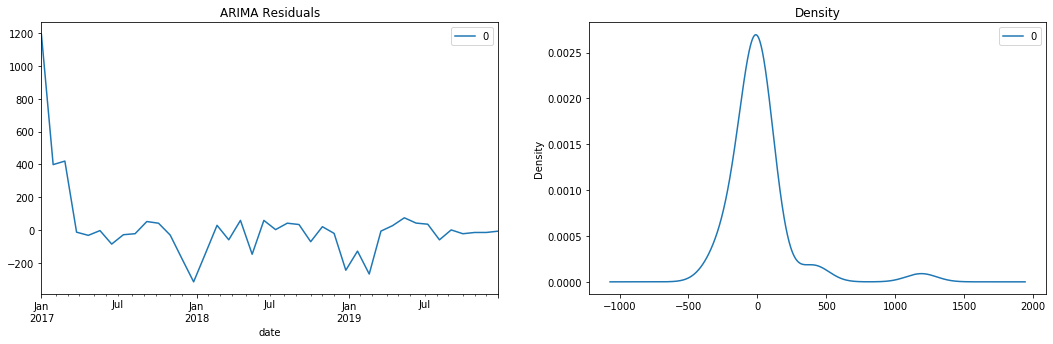

In [50]:
# Plot ARIMA residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
residuals.plot(title="ARIMA Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.legend()
plt.show()

#### Result
- RMSE: 85.051
- MAPE: 5.875 %
- AIC: 252.261
- BIC: 255.534
- Elapsed Time: 4 min

## 5. Holt-Winters Analysis

**Exponential smoothing** is a time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component.

There are three types of exponential smoothing; they are:
- Single Exponential Smoothing, or SES, for univariate data without trend or seasonality.
- Double Exponential Smoothing for univariate data with support for trends.
- Triple Exponential Smoothing, or **Holt-Winters** Exponential Smoothing, with support for both trends and seasonality.

We will use the implementation of <a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html" target="_blank">Holt-Winters Exponential Smoothing</a> provided by the statsmodels library.

### 5.1. Select best parameters for Holt-Winters model

This model has hyperparameters that control the nature of the exponential performed for the series, trend, and seasonality, specifically:
- **smoothing_level** (alpha): the smoothing coefficient for the level.
- **smoothing_slope** (beta): the smoothing coefficient for the trend.
- **smoothing_seasonal** (gamma): the smoothing coefficient for the seasonal component.
- **damping_slope** (phi): the coefficient for the damped trend.

There are other hyperparameters that the model will not automatically tune that you may want to specify; they are:
- **trend**: The type of trend component, as either “add” for additive or “mul” for multiplicative. Modeling the trend can be disabled by setting it to None.
- **damped**: Whether or not the trend component should be damped, either True or False.
- **seasonal**: The type of seasonal component, as either “add” for additive or “mul” for multiplicative. Modeling the seasonal component can be disabled by setting it to None.
- **seasonal_periods**: The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure.
- **use_boxcox**: Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.

In [51]:
# Create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    
    # Define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    
    models = list(itertools.product(t_params, d_params, s_params, p_params, b_params, r_params))
    
    return models

In [52]:
# Split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [53]:
# One-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t, d, s, p, b, r = config
    
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    
    # Fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    
    # Make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    
    return yhat[0]

# Walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    
    # Split dataset
    train, test = train_test_split(data, n_test)
    
    # Seed history with training dataset
    history = [x for x in train]
    
    # Step over each time-step in the test set
    for i in range(len(test)):
        
        # Fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        
        # Store forecast in list of predictions
        predictions.append(yhat)
        
        # Add actual observation to history for the next loop
        history.append(test[i])
    
    # Round predictions
    predictions = np.array([round(p) for p in predictions])
    
    # Estimate prediction error
    rmse = calc_rmse(test, predictions)
    mape = calc_mape(test, predictions)
    
    return rmse, mape

# Score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    rmse, mape = None, None
    
    # Convert config to a key
    key = str(cfg)
    
    # Show all warnings and fail on exception if debugging
    if debug:
        rmse, mape = walk_forward_validation(data, n_test, cfg)
        
        # Check for an interesting result
        if rmse is not None or mape is not None:
            print(' > Model %s, RMSE %.3f, MAPE %.3f' % (key, rmse, mape))
    else:
        # One failure during model validation suggests an unstable config
        try:
            # Never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                rmse, mape = walk_forward_validation(data, n_test, cfg)
        except:
            rmse = None
            mape = None
    
    return (key, rmse, mape)

# Run grid search configs
def hw_grid_search(data, param_list, n_test, parallel=True):
    scores = None
    
    if parallel:
        # Execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in param_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in param_list]
        
    # Remove empty results
    scores = [r for r in scores if r[1] is not None or r[2] is not None]
    
    # Sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    
    return scores

#### Run the grid search

In [54]:
# Run Holt-Winters fit
if run_fit:
    start_time = timeit.default_timer()
    
    # Calculation params
    param_list = exp_smoothing_configs([0, 4, 13])
    n_test = int(len(series_data.values) * perc_test)
    parallel = False
    
    # Grid search
    scores = hw_grid_search(series_data.values, param_list, n_test, parallel)
    print('Done Holt-Winters method')
    
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    print('Elapsed time', elapsed, 's')
    
    # List top 10 configs
    for cfg, rmse, mape in scores[:10]:
        print(cfg, rmse, mape)

### 5.2. Create Holt-Winters model

In [55]:
# Fitting a Holt-Winters Time Series model
history = series_data.values
model = ExponentialSmoothing(history, trend='mul', damped=True, seasonal='add', seasonal_periods=13)
model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)

In [56]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   40
Model:             ExponentialSmoothing   SSE                          89400.685
Optimized:                         True   AIC                            344.480
Trend:                   Multiplicative   BIC                            374.880
Seasonal:                      Additive   AICC                           388.691
Seasonal Periods:                    13   Date:                 Wed, 09 Sep 2020
Box-Cox:                          False   Time:                         10:49:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0526306                alpha                 True
smoothing_slope          

### 5.3. Producing and visualizing forecasts

In [57]:
# Get forecast n steps ahead in future (1 year)
pred_hw = model.forecast(steps=n_forecast)
y_forecasted = np.array([max(round(p),0) for p in pred_hw])

# Get confidence intervals of forecasts
pred_df = pd.DataFrame(y_forecasted, columns=['forecast'])
pred_df = pred_df.set_index(pred_bj.predicted_mean.index)
ci_beta = max(pred_hw) - max(pred_hw) * ci_alpha
pred_df['ci_inf'] = pred_hw - ci_beta
pred_df['ci_sup'] = pred_hw + ci_beta
pred_df

,forecast,ci_inf,ci_sup
2020-01-26,1205.0,1082.334739,1327.805849
2020-02-23,1227.0,1104.619997,1350.091107
2020-03-22,1064.0,941.623907,1187.095017
2020-04-19,1174.0,1050.814654,1296.285764
2020-05-17,1173.0,1049.919841,1295.390952
2020-06-14,1093.0,969.999722,1215.470832
2020-07-12,1196.0,1073.026486,1318.497596
2020-08-09,1188.0,1065.257690,1310.728801
2020-09-06,1190.0,1067.113411,1312.584522
2020-10-04,1136.0,1013.395346,1258.866456


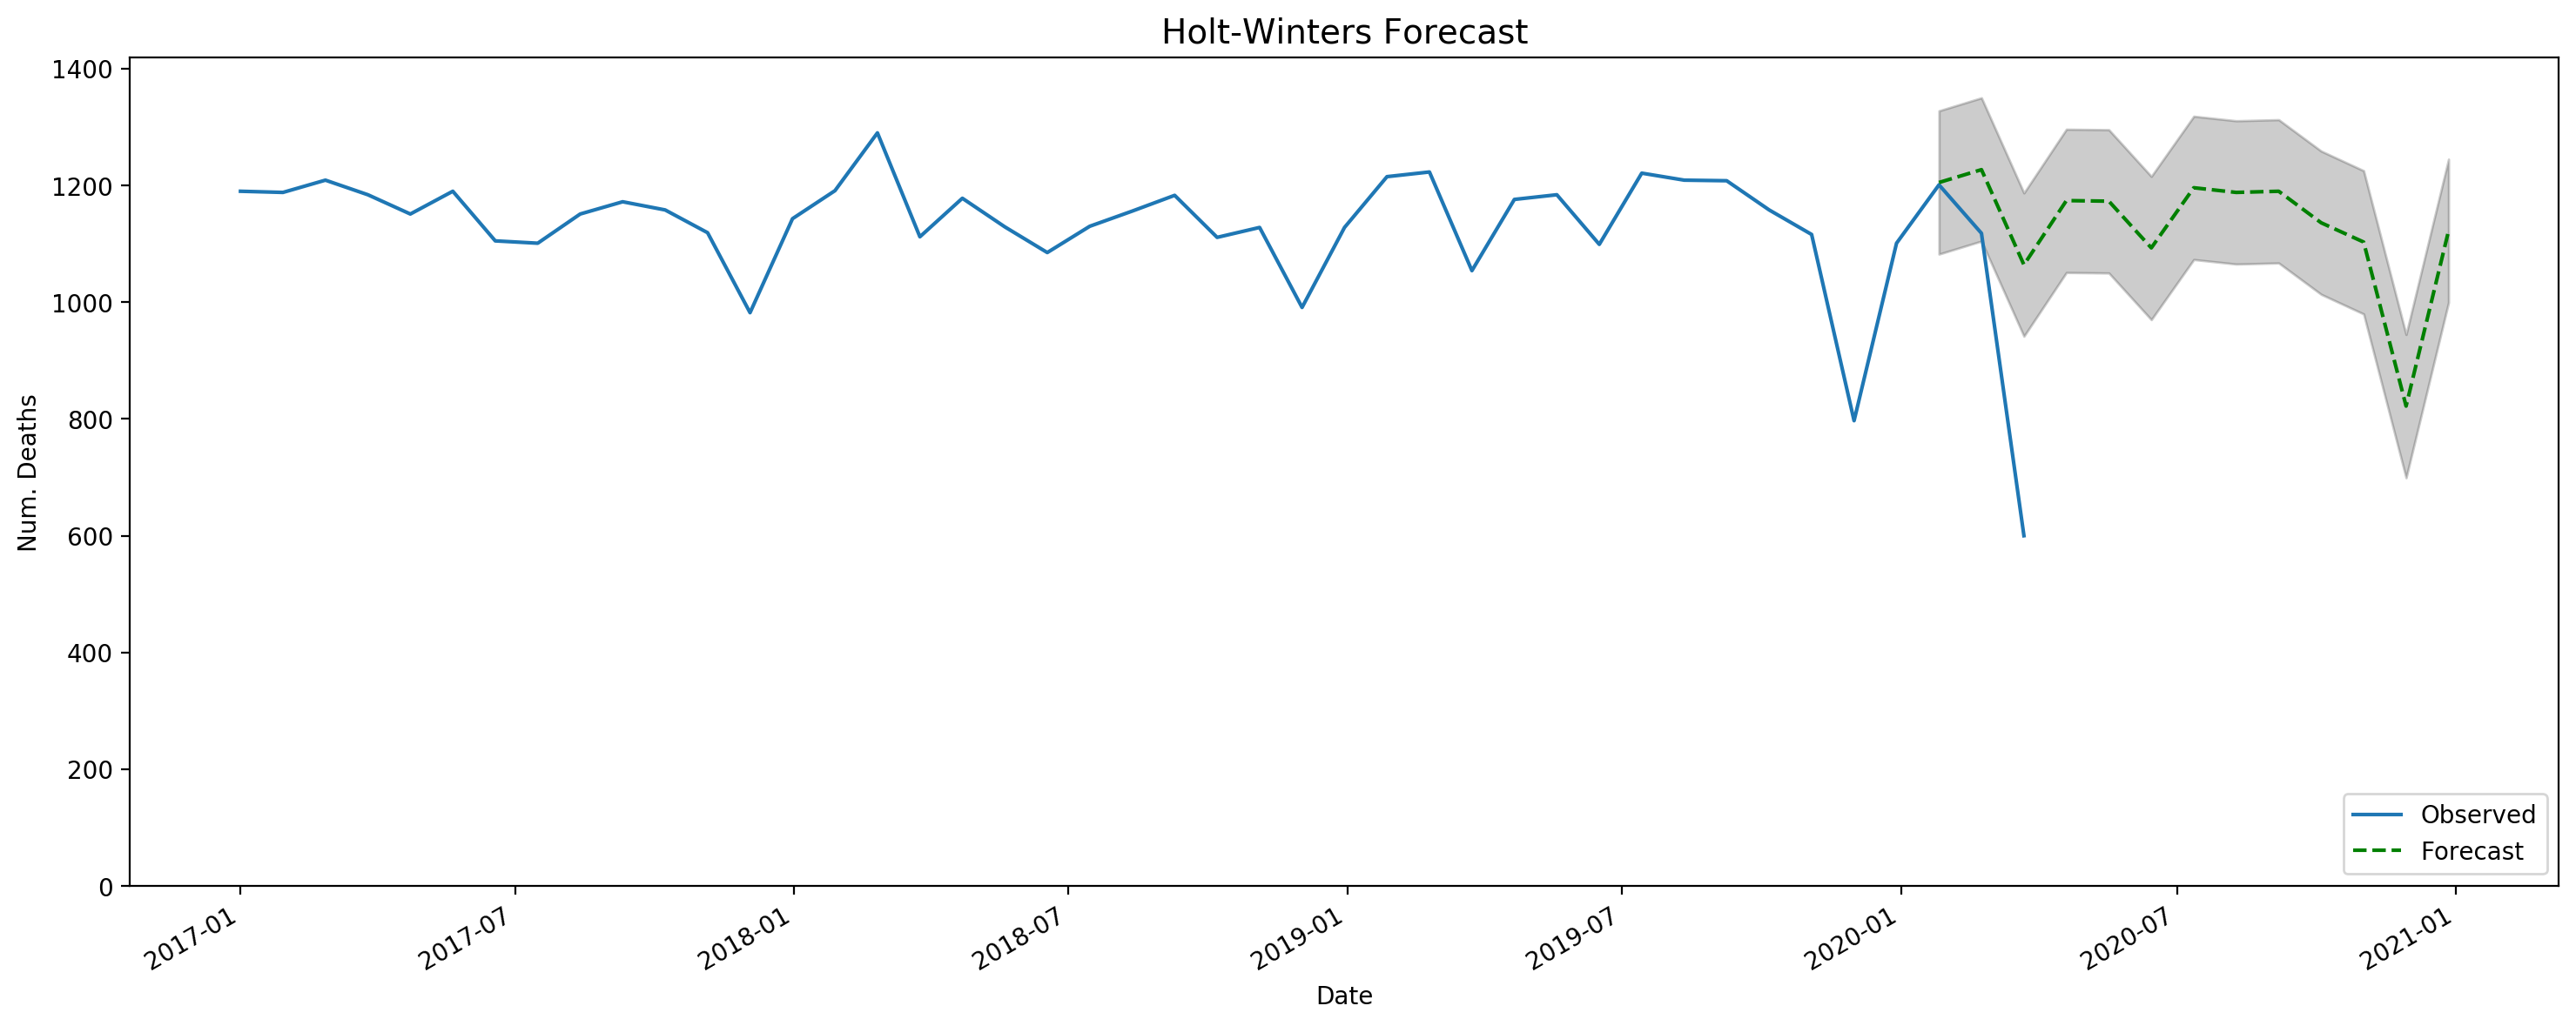

In [58]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = dataset['value'].plot(label='Observed')
pred_df.forecast.plot(ax=ax, label='Forecast', color='green', linestyle='dashed')
ax.fill_between(pred_df.index, pred_df.ci_inf, pred_df.ci_sup, color='k', alpha=.2)
plt.ylim((0, max_y))
plt.title('Holt-Winters Forecast', fontsize = 14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.legend(loc='lower right')
plt.show()

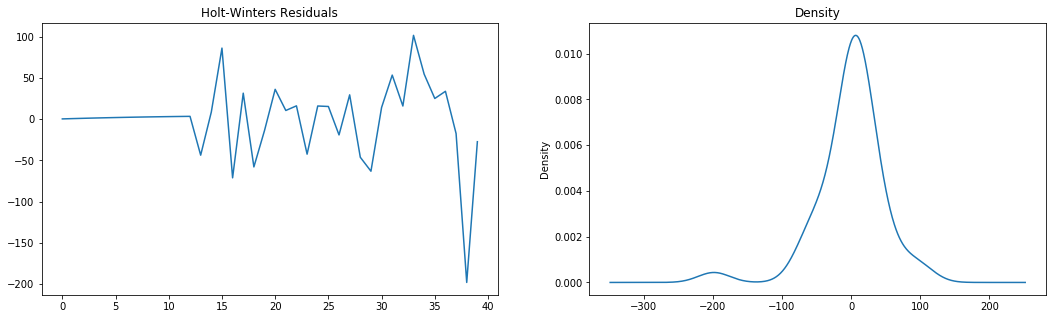

In [59]:
# Plot Holt-Winters residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
residuals.plot(title="Holt-Winters Residuals", ax=ax[0], legend=None)
residuals.plot(kind='kde', title='Density', ax=ax[1], legend=None)
plt.show()

#### Result
- RMSE: 83.463
- MAPE: 6.158 %
- AIC: 344.480
- BIC: 374.880
- Elapsed Time: 5 min

## 6. Compare Models

In [60]:
# Set normalized data
df = pd.DataFrame({
    'group': ['BL', 'ARIMA','HW'],
    'rmse': [0.833, 0.736, 0.716],
    'mape': [0.833, 0.722, 0.735],
    'aic': [0.833, 0.520, 0.705],
    'bic': [0.833, 0.525, 0.762],
    'time': [0.167, 0.515, 0.748]
})

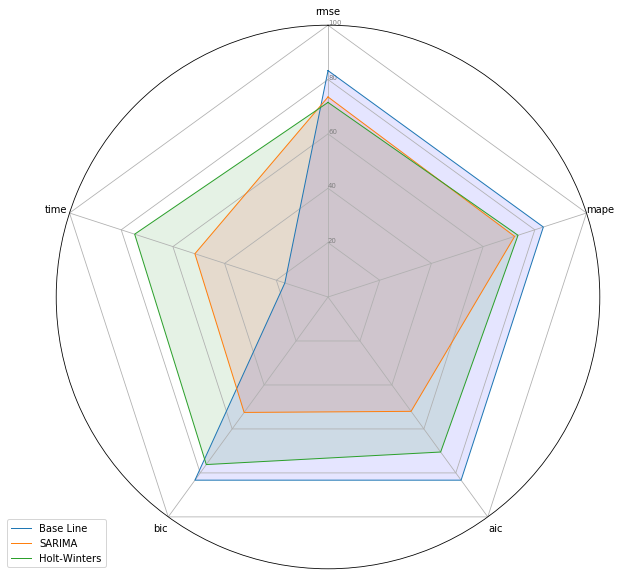

In [61]:
# PART 1: Create background
# Number of variable
categories = list(df)[1:]
num_vars = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialise the spider plot
plt.rcParams.update({'figure.figsize': (12, 10)})
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Pentagon instead of circle
gridlines = ax.yaxis.get_gridlines()
for gl in gridlines:
    gl.get_path()._interpolation_steps = num_vars

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1], ["20","40","60", "80", "100"], color="grey", size=7)
plt.ylim(0, 1)

# PART 2: Add plots
items = {
    'Base Line': 'b',
    'SARIMA': 'r',
    'Holt-Winters': 'g',
}

# Show items
ix = 0
for k, v in items.items():
    values = df.loc[ix].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=k)
    ax.fill(angles, values, v, alpha=0.1)
    ix += 1

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

---
End of analysis